In [1]:
import os
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
folder_dataset = 'data/original'
seed = 2704

In [3]:
files = [file for file in os.listdir(folder_dataset) if file.endswith('.jpg')]
len(files)

236

In [129]:
def load_image(img_name):
    img = cv.imread(os.path.join(folder_dataset, img_name))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img

def process_image(img, show_process=False, clahe_tile=(19,19), kernel_size=(37,37)):
    # Preprocess
    #smoothed = cv.blur(img,(5,5))
    denoise = cv.fastNlMeansDenoising(img,None,21,7)
    # Convert to gray
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # CLAHE
    clahe_filter = cv.createCLAHE(clipLimit=3,tileGridSize=clahe_tile)
    clahe = clahe_filter.apply(img_gray)
    #clahe = cv.equalizeHist(img_gray)
    # Otsu
    _, otsu = cv.threshold(clahe,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
    # Closing (Dilate+Erode)
    kernel = np.ones(kernel_size,np.uint8)
    closing = cv.morphologyEx(otsu, cv.MORPH_OPEN, kernel)
    # Fill holes    
    holes = closing.copy()
    contours,_ = cv.findContours(holes,cv.RETR_CCOMP,cv.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        area = cv.contourArea(contour)
        if area<10000:
            cv.drawContours(holes,[contour],0,0, thickness=cv.FILLED)
    if show_process:
        if clahe_tile[0] != 19:
            fig, axs = plt.subplots(6, 1, figsize=(20,15)) 
        else:
            fig, axs = plt.subplots(1, 6, figsize=(20,5)) 
        axs[0].imshow(img)
        axs[0].axis('off')
        axs[0].set_title('(a) Original')
        axs[1].imshow(denoise)
        axs[1].axis('off')
        axs[1].set_title('(b) Preprocess')
        axs[2].imshow(clahe, cmap='gray')
        axs[2].axis('off')
        axs[2].set_title('(c) Gray and CLAHE')
        axs[3].imshow(otsu, cmap='gray')
        axs[3].axis('off')
        axs[3].set_title('(d) Otsu')
        axs[4].imshow(closing, cmap='gray')
        axs[4].axis('off')
        axs[4].set_title('(e) Closing')
        axs[5].imshow(holes, cmap='gray')
        axs[5].axis('off')
        axs[5].set_title('(f) Fill holes')
        #plt.show()
    return holes

In [130]:
def percentage_white_pixels(image, height):
    img_cut1 = image[0:height,:]
    total_pixels_section = img_cut1.shape[0]*img_cut1.shape[1]
    pwp1 = (np.count_nonzero(img_cut1 == 255)*100)/total_pixels_section
    
    img_cut2 = image[height:image.shape[0]-1,:]
    total_pixels_section = img_cut2.shape[0]*img_cut2.shape[1]
    pwp2 = (np.count_nonzero(img_cut2 == 255)*100)/total_pixels_section
    return [pwp1, pwp2]
    
def contour_feature(image, return_process=False):
    contours,_ = cv.findContours(image,cv.RETR_CCOMP,cv.CHAIN_APPROX_SIMPLE)
    img = cv.cvtColor(image,cv.COLOR_GRAY2RGB)
    biggest_contour = []
    biggest_area = 0
    final_data = {}
    for contour in contours:
        area = cv.contourArea(contour)
        if area>biggest_area:
            biggest_contour = contour
            biggest_area = area
    if biggest_area>0:
        #cv.drawContours(img, biggest_contour, -1, (0, 255, 0), 3)
        rows,cols = img.shape[:2]
        [vx,vy,x,y] = cv.fitLine(biggest_contour, cv.DIST_L2,0,0.01,0.01)
        m = (float(vy)/vx)[0]
        n = y- m*x
        final_data['m'] = m
        final_data['n'] = n
        
        center_x = img.shape[1]/2
        center_y = m*center_x + n        
        
        if center_y>1 and center_y<(rows-1):
            pwp1, pwp2 = percentage_white_pixels(image, int(center_y))
            if pwp1>pwp2:
                final_data['pwp1'] = pwp1
                final_data['pwp2'] = pwp2
            else:
                final_data['pwp2'] = pwp1
                final_data['pwp1'] = pwp2
        
        _,_,w,h = cv.boundingRect(biggest_contour)
        area = cv.contourArea(biggest_contour)
        rect_area = w*h
        extent = float(area)/rect_area
        final_data['extent'] = extent
        
        hull = cv.convexHull(biggest_contour)
        hull_area = cv.contourArea(hull)
        solidity = float(area)/hull_area
        final_data['solidity'] = solidity
        
        
        if return_process:
            # Draw line
            lefty = int((-x*vy/vx) + y)
            righty = int(((cols-x)*vy/vx)+y)
            cv.line(img,(cols-1,righty),(0,lefty),(0,255,0),2)
            
            cv.circle(img, (int(center_x),int(center_y)), radius=3, color=(255, 0, 0), thickness=-1)
            cv.line(img,(cols-1,center_y),(0,center_y),(255,0,0),2)
            
            #cv.drawContours(img, [biggest_contour], 0, (0,0,255), 3)
            final_data['img'] = img
    return final_data

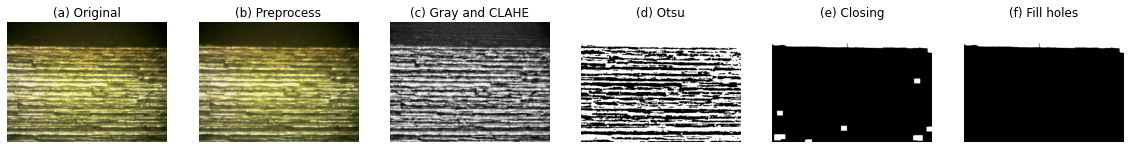

0.024003824 99.41941624365482 0.8718832020997376


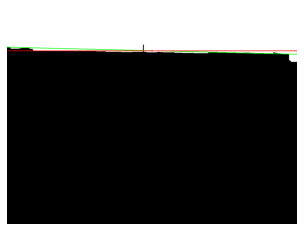

In [131]:
image = load_image(files[1])
img_process = process_image(image, True)
plt.savefig('data/test/'+files[1][:-4]+'_process.jpg', dpi=200, bbox_inches='tight', pad_inches=0)
plt.show()
data_vector =  contour_feature(img_process, True)  
print(data_vector['m'], data_vector['pwp1'], data_vector['pwp2'])
plt.imshow(data_vector['img'])
plt.axis('off')
plt.show()

0.011832192 98.71274038461539 7.175480769230769


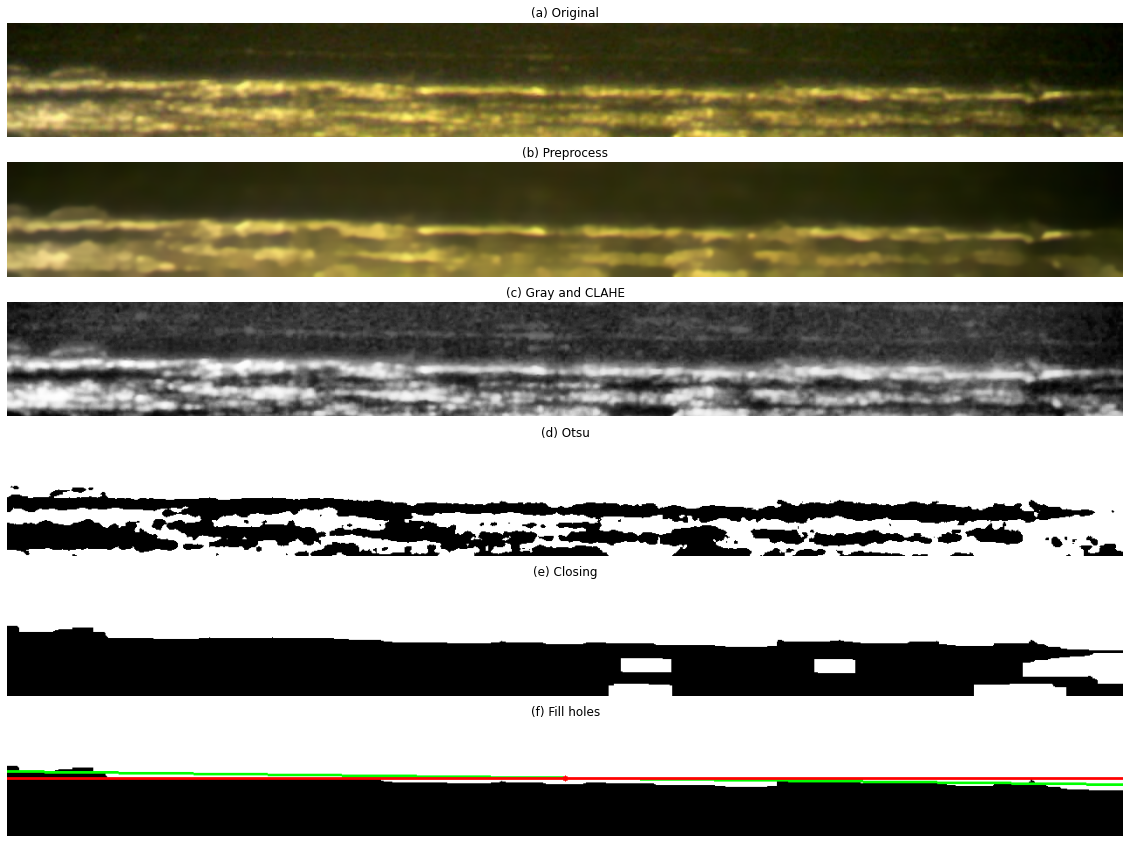

In [132]:
y1 = int(data_vector['m']*0 + data_vector['n'])-50
y2 = int(data_vector['m']*(img_process.shape[1]-1) + data_vector['n'])+50
img_cut=image[y1:y2,:]
img_process_cut = process_image(img_cut, True, clahe_tile = (5,5), kernel_size=(15,39))
plt.savefig('data/test/'+files[1][:-4]+'_process_cut.jpg', dpi=200, bbox_inches='tight', pad_inches=0)

data_vector_cut =  contour_feature(img_process_cut, True)  
print(data_vector_cut['m'], data_vector_cut['pwp1'], data_vector_cut['pwp2'])
plt.imshow(data_vector_cut['img'])
plt.axis('off')
plt.show()

In [122]:
img_process = process_image(files[100], True)
data_vector =  contour_feature(img_process, True)  
print(data_vector['m'], data_vector['pwp1'], data_vector['pwp2'])
plt.imshow(data_vector['img'])
plt.axis('off')
plt.show()

TypeError: Expected Ptr<cv::UMat> for argument 'src'

In [134]:
data = pd.DataFrame(columns=['img_name', 'folder','image']+['m', 'pwp1', 'pwp2', 'extent', 'solidity'])
for file in files:
    print(file)
    image = load_image(file)
    img_process = process_image(image, True)
    plt.savefig('data/test/'+file[:-4]+'_process.jpg', dpi=200, bbox_inches='tight', pad_inches=0)
    data_vector =  contour_feature(img_process, True)  
    y1 = int(data_vector['m']*0 + data_vector['n'])-50
    y1 = 0 if y1<0 else y1
    y2 = int(data_vector['m']*(img_process.shape[1]-1) + data_vector['n'])+50
    y2 = (img_process.shape[1]-1) if y2>(img_process.shape[1]-1) else y2
    if y1>y2:
        copy_y = y1
        y1 = y2
        y2 = copy_y
    img_cut=image[y1:y2,:]
    if "pwp1" in data_vector and data_vector['pwp1']>80 and img_cut.shape[0]>10:
        img_process_cut = process_image(img_cut, clahe_tile = (5,5), kernel_size=(15,39))
        plt.savefig('data/test/'+file[:-4]+'_process_cut.jpg', dpi=200, bbox_inches='tight', pad_inches=0)
        data_vector =  contour_feature(img_process_cut, True)  
        if "pwp1" in data_vector:
            data = data.append({'img_name': file[:-4],'folder': int(file[6:8]), 'image': int(file[13:-4]), 'm':data_vector['m'], 'pwp1':data_vector['pwp1'], 'pwp2':data_vector['pwp2'], 'extent':data_vector['extent'], 'solidity':data_vector['solidity']}, ignore_index=True)
    plt.close('all') 
data.head()

Pieza_01_foto0.jpg
Pieza_01_foto00.jpg
Pieza_01_foto0118.jpg
Pieza_01_foto0119.jpg
Pieza_01_foto0138.jpg
Pieza_01_foto0152.jpg
Pieza_01_foto0153.jpg
Pieza_01_foto0184.jpg
Pieza_01_foto0185.jpg
Pieza_01_foto0219.jpg
Pieza_01_foto0255.jpg
Pieza_01_foto0277.jpg
Pieza_01_foto0318.jpg
Pieza_01_foto0319.jpg
Pieza_01_foto0342.jpg
Pieza_01_foto0344.jpg
Pieza_01_foto0369.jpg
Pieza_01_foto038.jpg
Pieza_01_foto0416.jpg
Pieza_01_foto0437.jpg
Pieza_01_foto0460.jpg
Pieza_01_foto0461.jpg
Pieza_01_foto0521.jpg
Pieza_01_foto0545.jpg
Pieza_01_foto076.jpg
Pieza_01_foto118.jpg
Pieza_01_foto119.jpg
Pieza_01_foto138.jpg
Pieza_01_foto152.jpg
Pieza_01_foto153.jpg
Pieza_01_foto184.jpg
Pieza_01_foto185.jpg
Pieza_01_foto219.jpg
Pieza_01_foto255.jpg
Pieza_01_foto277.jpg
Pieza_01_foto318.jpg
Pieza_01_foto319.jpg
Pieza_01_foto342.jpg
Pieza_01_foto344.jpg
Pieza_01_foto368.jpg
Pieza_01_foto369.jpg
Pieza_01_foto39.jpg
Pieza_01_foto416.jpg
Pieza_01_foto437.jpg
Pieza_01_foto460.jpg
Pieza_01_foto461.jpg
Pieza_01_foto521.

,img_name,folder,image,m,pwp1,pwp2,extent,solidity
0,Pieza_01_foto0,1,0,0.020139,96.835938,9.816810,0.592410,0.801934
1,Pieza_01_foto00,1,0,0.011832,98.712740,7.175481,0.857837,0.956964
2,Pieza_01_foto0118,1,118,0.010924,98.692367,7.415865,0.863399,0.952401
3,Pieza_01_foto0119,1,119,0.001965,99.852273,6.478248,0.907968,0.947984
4,Pieza_01_foto0138,1,138,0.007898,93.031506,7.266996,0.698060,0.740001


In [135]:
data_category = pd.read_csv('data/info_category.csv', delimiter=';', decimal=".")
data_category = data_category[data_category.category>0]
data = data_category.merge(data, left_on=['img_name','folder','image'], right_on=['img_name','folder','image'])
data.to_csv('data/data_category.csv', index=False, sep=';', decimal=".")

In [136]:
data = pd.read_csv('data/data_category.csv', delimiter=';', decimal=".")

In [137]:
data

,img_name,folder,image,category,m,pwp1,pwp2,extent,solidity
0,Pieza_01_foto0,1,0,2,0.020139,96.835938,9.816810,0.592410,0.801934
1,Pieza_01_foto39,1,39,1,0.008291,98.190569,4.650649,0.856781,0.947534
2,Pieza_01_foto76,1,76,1,0.011559,97.533854,4.935826,0.862357,0.955662
3,Pieza_01_foto118,1,118,1,0.011904,97.862449,6.174769,0.863340,0.955806
4,Pieza_01_foto119,1,119,1,-0.001789,99.136029,4.915865,0.871196,0.932409
...,...,...,...,...,...,...,...,...,...
152,Pieza_13_foto173,13,173,2,0.004974,97.092014,5.342654,0.766577,0.841032
153,Pieza_13_foto232,13,232,1,0.001922,99.877717,4.895342,0.879572,0.905619
154,Pieza_13_foto233,13,233,2,-0.001883,98.658854,4.910083,0.729956,0.814290
155,Pieza_13_foto243,13,243,3,0.014563,98.918679,13.515625,0.882470,0.935475


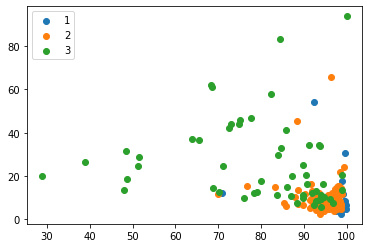

In [138]:
for type_label in [1,2,3]:
    data_category = data[data.category==type_label]
    plt.scatter(data_category.loc[:,"pwp1"], data_category.loc[:,"pwp2"], label=type_label)
    plt.legend()

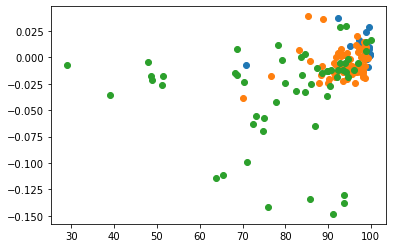

In [139]:
for type_label in [1,2,3]:
    data_category = data[data.category==type_label]
    plt.scatter(data_category.loc[:,"pwp1"], data_category.loc[:,"m"], label=type_label)

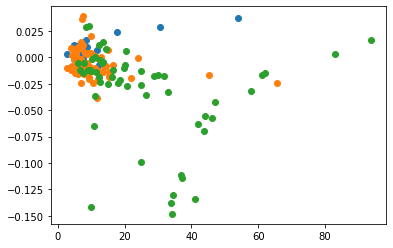

In [140]:
for type_label in [1,2,3]:
    data_category = data[data.category==type_label]
    plt.scatter(data_category.loc[:,"pwp2"], data_category.loc[:,"m"], label=type_label)

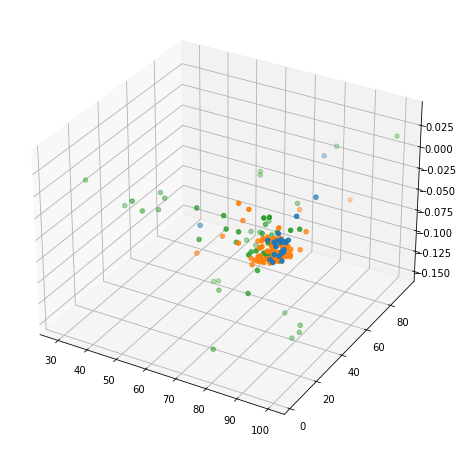

In [141]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
for type_label in [1,2,3]:
    data_category = data[data.category==type_label]
    ax.scatter(data_category.loc[:,"pwp1"],data_category.loc[:,"pwp2"],data_category.loc[:,"m"], label=type_label)
plt.show()

In [142]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score
from sklearn import preprocessing

In [152]:
X_values = data[['m', 'pwp1', 'pwp2', 'extent', 'solidity']]
y_values = data[['category']]

X_train, X_test, y_train, y_test = train_test_split(X_values, y_values.values.ravel(), test_size=0.2, random_state=seed)

In [167]:

models = [
            'ADB',
            'GBC',
            'RFC',
            'KNC'
         ]
clfs = [
        AdaBoostClassifier(random_state=seed),
        GradientBoostingClassifier(random_state=seed),
        RandomForestClassifier(random_state=seed,n_jobs=-1),
        KNeighborsClassifier(n_jobs=-1)
        ]
params = {
            models[0]: {'n_estimators':range(100,150,50)},
            models[1]: {'n_estimators':range(100,150,50), 'max_depth':range(5,9,2)},
            models[2]: {'criterion':['entropy'], 'n_estimators':range(10,100,10)},
            models[3]: {'n_neighbors':range(3,10), 'weights':['distance', 'uniform'],'leaf_size':range(5,30,5)}
         }

In [172]:
test_scores = []
y_estimation = 0
for name, estimator in zip(models,clfs):
    clf = GridSearchCV(estimator, params[name], scoring='accuracy', refit='True', n_jobs=-1, cv=10)
    clf.fit(X_train, y_train)
    test_scores.append((name, clf.best_params_, clf.best_score_))

In [173]:
results = pd.DataFrame(data=test_scores, columns=["name", "params", "acc_score"])
results.columns = ["Model", "Parameters", "Accuracy"]
results = results.sort_values(by=['Accuracy'], ascending=False,ignore_index=True)
results.Accuracy = results.Accuracy.round(4)
pd.set_option('display.max_colwidth', None)
results.to_latex('grid_search.txt', index = False, longtable = True)
results.head()

,Model,Parameters,Accuracy
0,RFC,"{'criterion': 'entropy', 'n_estimators': 10}",0.7442
1,ADB,{'n_estimators': 100},0.7026
2,KNC,"{'leaf_size': 5, 'n_neighbors': 8, 'weights': 'uniform'}",0.6853
3,GBC,"{'max_depth': 7, 'n_estimators': 100}",0.6724


In [174]:
print("Best classifier: "+results.loc[0,'Model'])
print('params: '+str(results.loc[0,'Parameters']))
print('Accuracy test: '+str(results.loc[0,'Accuracy']))

Best classifier: RFC
params: {'criterion': 'entropy', 'n_estimators': 10}
Accuracy test: 0.7442


In [175]:
model_reduced = RandomForestClassifier(random_state=seed,n_jobs=-1, criterion = 'entropy', n_estimators=10)
model_reduced = model_reduced.fit(X_train, y_train)
y_predict_train = model_reduced.predict(X_train)
print(classification_report(y_train,y_predict_train, digits=4))
y_predict= model_reduced.predict(X_test)
print(classification_report(y_test,y_predict, digits=4))

              precision    recall  f1-score   support

           1     0.8889    0.8889    0.8889        18
           2     0.9375    0.9677    0.9524        62
           3     1.0000    0.9556    0.9773        45

    accuracy                         0.9520       125
   macro avg     0.9421    0.9374    0.9395       125
weighted avg     0.9530    0.9520    0.9522       125

              precision    recall  f1-score   support

           1     0.8333    0.7143    0.7692         7
           2     0.6923    0.6429    0.6667        14
           3     0.6154    0.7273    0.6667        11

    accuracy                         0.6875        32
   macro avg     0.7137    0.6948    0.7009        32
weighted avg     0.6967    0.6875    0.6891        32



In [ ]:
#ampliar el dataset dividiendo cada imagen verticalmente por ejemplo 5-10 divisiones